# Teknisk _AI for Dummies_ - Hvordan ser det ut å jobbe med nevrale nettverk nå til dags?
Denne er ment for å gi et kjapt overblikk av hvordan kode ser ut når man jobber med maskinlæring / dyp læring.

## Vektorer
I dyp læring er all data i form av vektorer, matriser og tensorer. Min faglige erfaring tilsier at disse begrepene er generelle og beskriver bare en samling verdier. Rent praktisk er det flerdimensjonale lister/arrays.

In [1]:
import numpy as np

In [2]:
# En vektor med 

## Dimensjoner og _shapes_
Fra matematikken vet vi at en liste med feks. 3 tall definerer en vektor/punkt som lever i et tre-dimensjonalt rom.  

## Rammeverket PyTorch

PyTorch er et av flere biblioteker som brukes til trening av dype nevrale nettverk. Det andre kjente alternativet er TensorFlow. Hva man velger avhenger mye av smak, men begge har sine fordeler og ulemper. Jeg liker PyTorch fordi mindre av treningsprosessen blir gjemt og man har mer frihet.
PyTorch omfatter mye av den funksjonaliteten man finner i Numpy, men tilbyr metoder for trening og konstruksjon av nevrale nettverk. En `np.ndarray` er ekvivalent med en `torch.Tensor`.

In [3]:
import torch

In [4]:
tensor = torch.randn(2, 2)
print(tensor)
print(f"Default tensor location: {tensor.device}")

tensor([[-1.6319,  0.6300],
        [ 1.8345, -1.4373]])
Default tensor location: cpu


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
tensor.to(device)

tensor([[-1.6319,  0.6300],
        [ 1.8345, -1.4373]], device='cuda:0')

## Oppsett av nevrale nettverk med PyTorch
Et nevralt nettverk har vanligvis en kompleks struktur. Likevel består de av flere isolerte komponenter, og disse finner man i `torch.nn`. 

De fleste komponentene blir et såkalt _lag_ i nettverket, mens andre komponenter anvendes på eksisterende lag (feks aktiveringsfunksjoner). 

Den enkleste er `torch.nn.Linear`, og setter opp et lineært lag. Matematisk gjør den en lineær transformasjon fra et vektorrom til et annet. Feks kan den ta inn en vektor med 5 elementer, og outputte en vektor med 3 elementer:

<img src="nn_5in_3out-cropped.svg" width="500px" height="auto" alt="SVG Image"  style="filter: invert(100%); "/>


In [7]:
import torch.nn as nn
layer = nn.Linear(in_features=5, out_features=3) # Construct layer

data = torch.rand(size=(1,5)) # Create random input data
print(f"Input vector: {data}")
output = layer(data) # Feed data into layer
print(f"Output vector: {output}")

Input vector: tensor([[0.9561, 0.7344, 0.0922, 0.4386, 0.0674]])
Output vector: tensor([[ 0.7995, -0.5531,  0.7010]], grad_fn=<AddmmBackward0>)


In [8]:
print(f"Weights:\n{layer.weight.data}")
print(f"Weight shape: {layer.weight.shape}\n")

print(f"Bias:\n{layer.bias.data}")
print(f"Bias shape: {layer.bias.shape}")

Weights:
tensor([[ 0.2700, -0.0315, -0.1026,  0.3540,  0.1387],
        [ 0.0261, -0.2966, -0.2097, -0.1013,  0.2018],
        [ 0.4385, -0.0545,  0.2141, -0.3416,  0.2625]])
Weight shape: torch.Size([3, 5])

Bias:
tensor([ 0.4093, -0.3101,  0.4343])
Bias shape: torch.Size([3])


Vektene og biaset er verdiene som skal . Når man sender input-vektoren inn skjer følgende operasjon bak gardinene:

In [9]:
data @ layer.weight.T + layer.bias

tensor([[ 0.7995, -0.5531,  0.7010]], grad_fn=<AddBackward0>)

### Aktiveringsfunksjoner

Det lineære laget utfører en lineær operasjon. Fleksibiliteten kommer derimot av såkalte _aktiveringsfunksjoner_ som utfører ikke-lineære operasjoner på data. Disse inneholder **vanligvis** ikke trenbare parametre. De enkleste opererer på hvert element individuelt, som feks Sigmoid. Vi ser på et en-dimensjonalt-case for å visualisere det enkelt.

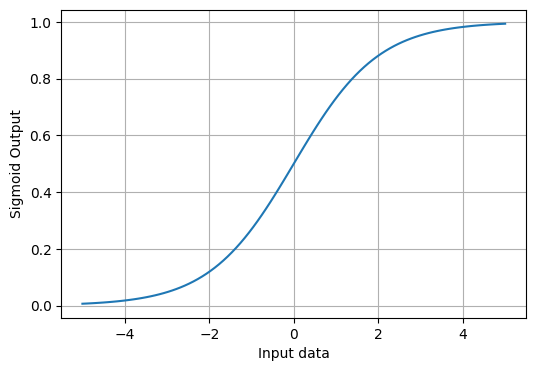

In [10]:
import matplotlib.pyplot as plt
sigmoid = nn.Sigmoid()
assert not hasattr(sigmoid, "weights") # No learnable weights

data = torch.linspace(start=-5, end=5, steps=100) # One-dimensional vector with 100 elements 
output = sigmoid(data)

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(data, output)
ax.set_xlabel("Input data")
ax.set_ylabel("Sigmoid Output")

# Add a grid
ax.grid(True)

# Show the plot
plt.show()


Et viktig poeng er at aktiveringsfunksjoner ikke modifiserer _shapen_ til tensoren. Dette kan demonstreres på en tensor med flere shape-dimensjoner. 

In [11]:
data = torch.rand(30, 5, 15)
print(f"shape before activation function: {data.shape}")
data = sigmoid(data)
shape2 = print(f"shape after activation function: {data.shape}")

shape before activation function: torch.Size([30, 5, 15])
shape after activation function: torch.Size([30, 5, 15])


En annen viktig er `nn.Softmax`, og brukes til å transformere en vektor til elementer som summeres til 1. Passer fint som siste lag i et nettverk man ønsker skal modellere en sannsynlighetsfordeling. 

## Klassifisering av sifre
Vi skal sette opp et nevralt nettverk som er i stand til å klassifisere sifre. Til det trenger vi det lett tilgjengelige MNIST-datasettet. Dette lastes ned gjennom torchvision-biblioteket. Torchvision-biblioteket er et hjelpebibliotek som tilbyr verktøy for Computer Vision-oppgaver. 

Datasett kommer vanligvis i et rå-format, og må behandles for å tilpasse det oppgaven vi skal gjøre. I dette tilfellet får vi PNG-bilder som må gjøres om til tensorer. Vi normaliserer også bildene for å få [bedre resultater](https://developers.google.com/machine-learning/data-prep/transform/normalization). Behandlingen gjøres med `torchvision.transforms`-biblioteket. 

In [46]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

# Pipeline of processing operations
image_processing = transforms.Compose([
    transforms.ToTensor(), # Cast into tensor
    transforms.Normalize((0.5,), (0.5,)) # Pixel-values will range in [-1, 1]
    ])

train_dataset = MNIST(root='./data', train=True, transform=image_processing, download=True)
test_dataset = MNIST(root='./data', train=False, transform=image_processing, download=True) # Test data for later

I maskinlæring trener man flere iterasjoner på samme datasettet, 

In [29]:
from torch.utils.data import DataLoader
data_loader = DataLoader(train_dataset, shuffle=True, batch_size=16) # Iterable that provides 16 data samples each iteration

data, labels = next(iter(data_loader)) # Retrieve a batch of data samples and labels for inspection purposes
print(f"Shape of data batch: {data.shape}")


Shape of data batch: torch.Size([16, 1, 28, 28])


Tensoren inneholder 16 eksemplarer, 1 kanal for farge (grayscale), 28 piksler i høyden, og 28 piksler i bredden.
Vi kan visualisere et tilfeldig eksemplar.

Shown below is the digit 1


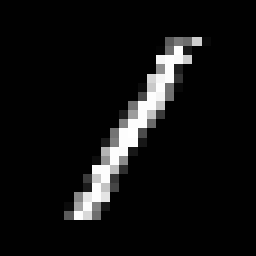

In [118]:
import random
rand_index = random.randint(0, len(data)-1)
data_sample = data[rand_index]
label_sample = labels[rand_index]
image = transforms.functional.resize(data_sample, (256, 256), interpolation=transforms.InterpolationMode.NEAREST)
image = transforms.functional.to_pil_image(image)
print(f"Shown below is the digit {label_sample}")
image

### Vi trenger et nettverk
Alle lag i PyTorch arver fra `nn.Module`. Fra [dokumentasjonen](https://pytorch.org/docs/stable/generated/torch.nn.Module.html):

>Base class for all neural network modules. 
>
>Your models should also subclass this class.
>
>Modules can also contain other Modules, allowing to nest them in a tree structure. You can assign the submodules as regular attributes:

Trestrukturen som snakkes om er veldig nyttig. Endringer vi gjør på toppen av treet vil propageres ned til enkeltmodulene. Feks det å flytte parametrene over på en annen device.

Vi husker det enkle lineære laget og sigmoid-funksjonen. De arver fra `nn.Module`.

In [15]:
print(layer.__class__.__base__)
print(sigmoid.__class__.__base__)

<class 'torch.nn.modules.module.Module'>
<class 'torch.nn.modules.module.Module'>


In [92]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=28*28, out_features=100)
        self.layer2 = nn.Linear(in_features=100, out_features=42)
        self.layer3 = nn.Linear(in_features=42, out_features=10) # 10 digits to differentiate between

        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)

    def logits(self, data):
        flattened_data = torch.flatten(data, start_dim=1, end_dim=-1) # Flatten the tensor from shape (batch_size, 1, 28, 28) to shape (batch_size, 28 * 28)

        out = self.layer1(flattened_data)
        out = self.sigmoid(out)

        out = self.layer2(out)
        out = self.sigmoid(out)

        out = self.layer3(out)
        return out
    
    def forward(self, data):
        logits = self.logits(data)
        return self.softmax(logits)

In [100]:
model = Model()
model

Model(
  (layer1): Linear(in_features=784, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=42, bias=True)
  (layer3): Linear(in_features=42, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)

In [102]:
out = model.forward(data_sample[None, ...]) # [None, ...] adds a batch dimension
out 

tensor([[0.0745, 0.0896, 0.1095, 0.0668, 0.0776, 0.2076, 0.1580, 0.0759, 0.0807,
         0.0599]], grad_fn=<SoftmaxBackward0>)

### Trening
Vi ser fra resultatene at modellen ikke er i stand til å avgjøre hvilket siffer inputten var. 

Vi har modellen og datasettet. Da er det to viktige ting som mangler for å kunne oppnå en fungerende modell. 
- **En loss-funksjon som definerer objectivet**
    - Vi ønsker at modellen skal gi høyest sannsynlighet på det rette sifret.
- **En algoritme som utfører gradient descent, altså selve maskinlæringen**
    - Denne algoritmen skal ta utgangspunkt i losset for å optimere parametrene.
    - Man implementerer denne aldri selv, og finner de heller gjennom `torch.optim`.

Model(
  (layer1): Linear(in_features=784, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=42, bias=True)
  (layer3): Linear(in_features=42, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)